In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [44]:
files ={
    'Spanish' : 'Spanish',
    'English' : 'English',
    #'German1' : 'German',
    'German2' : 'German',
    'French1' : 'French',
    'French2' : 'French'
}

file_directory = os.getcwd()
extractedFeatures_folder = 'ExtractedFeatures/'

df_full = pd.DataFrame()
for file in files:
    df_language = pd.read_csv(file_directory + '/' + extractedFeatures_folder + '/' + file + '.csv', delimiter=";", encoding='utf-8')
    df_language['Class'] = files[file]
    df_full = pd.concat([df_full, df_language], ignore_index=True)
    df_full = df_full.reindex(range(df_full.shape[0]))

X = df_full.drop(['phrase', 'Class'], axis=1)
y = df_full['Class']

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
x_train, x_test, y_train, y_test = train_test_split(X, y)

In [4]:
x_train_scaled = StandardScaler().fit_transform(x_train)
x_test_scaled = StandardScaler().fit_transform(x_test)

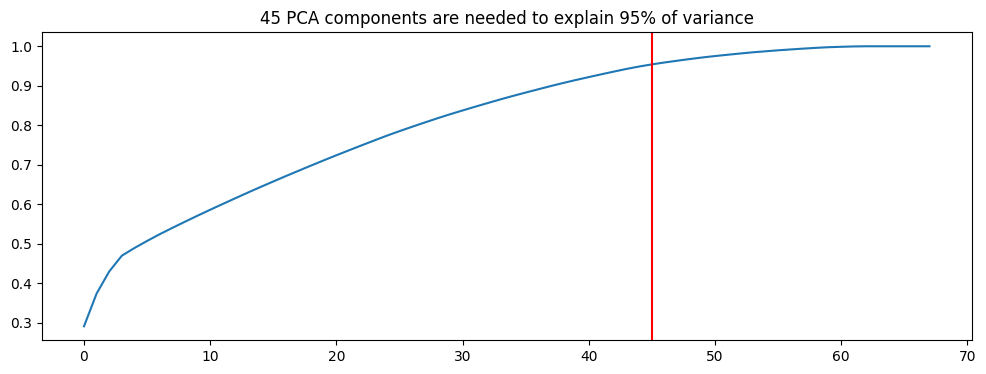

In [5]:
from sklearn.decomposition import PCA

pca_full = PCA(n_components=x_test.shape[1])
pca_full.fit(x_train_scaled)

cummulative_variance = pca_full.explained_variance_ratio_.cumsum()

# Find number of components needed to explain 95% of variance:
ind= np.argwhere(cummulative_variance>0.95)
Ncomponents_95 = ind[0].item()

fig = plt.figure(figsize=(12,4))
plt.plot(cummulative_variance)
plt.axvline(Ncomponents_95,c='r')
plt.title('{} PCA components are needed to explain 95% of variance'.format(Ncomponents_95))
plt.show()

In [6]:
pca95 = PCA(n_components=Ncomponents_95)
pca95_proj = pca95.fit_transform(x_train_scaled)

KNN

In [7]:
knn_raw = KNeighborsClassifier(n_neighbors=2) # load the model
knn_raw.fit(x_train_scaled,y_train) # fit the model using training data
y_test_pred_raw = knn_raw.predict(x_test_scaled)

cm_raw = confusion_matrix(y_test, y_test_pred_raw)

              precision    recall  f1-score   support

     Spanish       0.95      0.99      0.97      6825
     English       0.90      0.94      0.92      1086
      German       0.99      0.93      0.96      5209
      French       0.98      0.93      0.96      1323

    accuracy                           0.96     14443
   macro avg       0.95      0.95      0.95     14443
weighted avg       0.96      0.96      0.96     14443



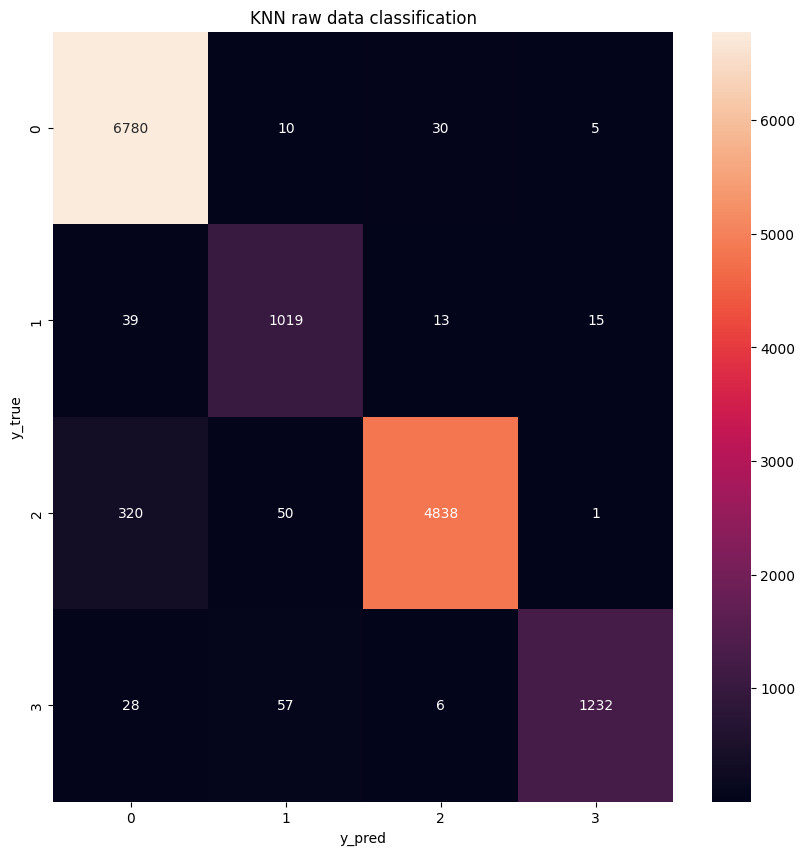

In [8]:
fig = plt.figure(figsize=(10, 10))

sns.heatmap(cm_raw,annot = True,fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title('KNN raw data classification')

label_names = ['Spanish','English','German','French']
print(classification_report(y_test, y_test_pred_raw, target_names=label_names))

https://heartbeat.comet.ml/using-machine-learning-for-language-detection-517fa6e68f22

In [45]:
extractedText_folder = 'ExtractedText/'

df_cv_full = pd.DataFrame()
for file in files:
    df_cv_language = pd.read_csv(file_directory + '/' + extractedText_folder + '/' + file + '.txt', delimiter="qwer", names=["Sentence"], encoding='utf-8', header=None)
    df_cv_language['Class'] = files[file]
    df_cv_full = pd.concat([df_cv_full, df_cv_language.iloc[:5000]], ignore_index=True)
    df_cv_full = df_cv_full.reindex(range(df_cv_full.shape[0]))

x_cv = df_cv_full['Sentence']
y_cv = df_cv_full['Class']

C:\Users\sergi\AppData\Local\Temp\ipykernel_19996\3671380936.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_cv_language = pd.read_csv(file_directory + '/' + extractedText_folder + '/' + file + '.txt', delimiter="qwer", names=["Sentence"], encoding='utf-8', header=None)


In [46]:
df_cv_full["Class"].value_counts()

Spanish    5000
English    5000
German     5000
French     4490
Name: Class, dtype: int64

In [47]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_cv = le.fit_transform(y_cv)

In [48]:
import re

text_list = []
for text in x_cv:
        text = re.sub(r'[!@#$(),n"%^*?:;~`0-9]', ' ', text)
        text = re.sub(r'[[]]', ' ', text)
        text = text.lower()
        text_list.append(text)

In [49]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
x_cv_n = cv.fit_transform(x_cv).toarray()
x_cv_n.shape

(19490, 45680)

In [51]:
x_cv_train, x_cv_test, y_cv_train, y_cv_test = train_test_split(x_cv_n, y_cv, test_size = 0.20)

In [52]:
from sklearn.naive_bayes import MultinomialNB
modelMNB = MultinomialNB()
modelMNB.fit(x_cv_train, y_cv_train)

MultinomialNB()

In [53]:
y_cv_prediction = modelMNB.predict(x_cv_test)

In [54]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_cv = accuracy_score(y_cv_test, y_cv_prediction)
confusion_m_cv = confusion_matrix(y_cv_test, y_cv_prediction)
print("The accuracy is :", accuracy_cv)

The accuracy is : 1.0


In [71]:
print(classification_report(y_cv_test, y_cv_prediction, target_names=label_names))

              precision    recall  f1-score   support

     Spanish       1.00      1.00      1.00      1022
     English       1.00      1.00      1.00       861
      German       1.00      1.00      1.00      1045
      French       1.00      1.00      1.00       970

    accuracy                           1.00      3898
   macro avg       1.00      1.00      1.00      3898
weighted avg       1.00      1.00      1.00      3898



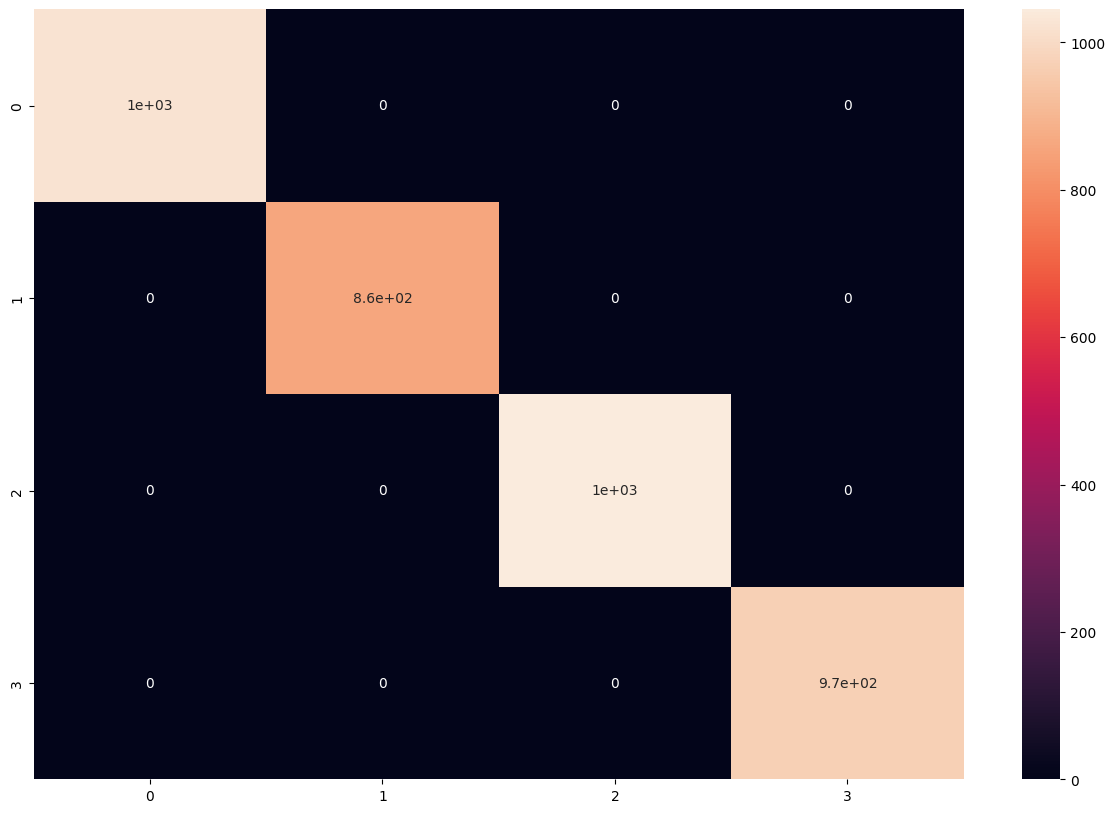

In [55]:
plt.figure(figsize=(15,10))
sns.heatmap(confusion_m_cv, annot = True)
plt.show()

In [67]:
def lang_predict(text):
     x = cv.transform([text]).toarray() 
     lang = modelMNB.predict(x)
     lang = le.inverse_transform(lang) 
     print("The language is in",lang[0])

In [62]:
lang_predict("Hola buenos días qué tal estás")

Spanish
The langauge is in Spanish


In [63]:
lang_predict("Warum bist du")

German
The langauge is in German


In [64]:
lang_predict("Salut je suis rot")

French
The langauge is in French


In [65]:
lang_predict("I do not know")

English
The langauge is in English


In [68]:
lang_predict("Mi casa es azul")

The langauge is in Spanish


In [69]:
lang_predict("The moon")

The langauge is in English


In [70]:
lang_predict("Nein")

The langauge is in German


In [ ]:
from pykalman import KalmanFilter
import numpy as np

# Define the initial state and transition matrix
x_init = np.array([0.25, 0.25, 0.25, 0.25])
transition_matrix = np.eye(4)

# Define the measurement matrix and measurement noise
# measurement_matrix = [[1, 0, 0, 0],
#                       [0, 1, 0, 0],
#                       [0, 0, 1, 0],
#                       [0, 0, 0, 1]]
measurement_matrix = np.eye(4)
measurement_noise = np.eye(4)*0.01
#measurement_noise = np.diag([0.1, 0.1, 0.1, 0.1])

# Define the process noise
process_noise = np.eye(4)*0.01

# Create the Kalman filter
kf = KalmanFilter(transition_matrices=transition_matrix,
                  observation_matrices=measurement_matrix,
                  initial_state_mean=x_init,
                  observation_covariance=measurement_noise,
                  transition_covariance=process_noise
                  )

# Generate some fake measurements
measurements = np.array([1, 0, 0, 0])

# Run the Kalman filter
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
print(filtered_state_means)

In [ ]:
measurements = np.array([1, 1, 1, 1])

# Run the Kalman filter
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
print(filtered_state_means)

In [ ]:
class KalmanFilter:
    def __init__(self, initial_state, initial_covariance, transition_matrix, observation_matrix, process_noise_covariance, observation_noise_covariance):
        self.state = initial_state
        self.covariance = initial_covariance
        self.transition_matrix = transition_matrix
        self.observation_matrix = observation_matrix
        self.process_noise_covariance = process_noise_covariance
        self.observation_noise_covariance = observation_noise_covariance

    def predict(self):
        self.state = np.dot(self.transition_matrix, self.state)
        self.covariance = np.dot(np.dot(self.transition_matrix, self.covariance), self.transition_matrix.T) + self.process_noise_covariance

    def update(self, observation):
        innovation = observation - np.dot(self.observation_matrix, self.state)
        innovation_covariance = np.dot(np.dot(self.observation_matrix, self.covariance), self.observation_matrix.T) + self.observation_noise_covariance
        kalman_gain = np.dot(np.dot(self.covariance, self.observation_matrix.T), np.linalg.inv(innovation_covariance))
        self.state = self.state + np.dot(kalman_gain, innovation)
        self.covariance = np.dot((np.eye(self.state.shape[0]) - np.dot(kalman_gain, self.observation_matrix)), self.covariance)


In [ ]:
# Initial state estimate (probabilities for each language)
initial_state = np.array([0.25, 0.25, 0.25, 0.25])  # Assuming equal probability for each language
# Initial covariance matrix
initial_covariance = np.eye(4) * 0.01  # Assuming small uncertainty
# Transition matrix (identity matrix as we don't have a dynamic model for language probabilities)
transition_matrix = np.eye(4)
# Observation matrix (identity matrix as we directly observe the language)
observation_matrix = np.eye(4)
# Process noise covariance (assuming small process noise)
process_noise_covariance = np.eye(4) * 0.001
# Observation noise covariance (assuming small observation noise)
observation_noise_covariance = np.eye(4) * 0.001

# Initialize Kalman filter
kalman_filter = KalmanFilter(initial_state, initial_covariance, transition_matrix, observation_matrix, process_noise_covariance, observation_noise_covariance)


In [ ]:
# Example observation for English language
observation = np.array([0, 1, 0, 0])  # English

# Update the Kalman filter with the observation
kalman_filter.update(observation)

# After update, you can get the current state (language probabilities)
current_language_probabilities = kalman_filter.state

# Print the current language probabilities
print("Current Language Probabilities:", current_language_probabilities)
